# 多臂老虎机 （Multi-armed Bandits）  

## 介绍（Introduction）

在本次作业中，利用学过的强化学习知识实现K臂老虎机问题求解。

本次实验需要没有用到额外数据，数据均来自和老虎机（环境）在线交互：
***
# 涉及强化学习核心概念回顾：
- 智能体：设计的算法，核心是策略
- 环境：K臂老虎机
- 动作：选择那一个arm
- 动作空间大小：K， 可以记录为$\mathcal{A} =\{a_1, a_2, ...., a_K\}$, 其中$a_k$代表拉动第$k$个arm的动作。
- 状态空间：只有一个状态
- 奖励：每次动作后，老虎机返回的奖励
- 学习目标：T次拉杆后获得最高奖励: $max \sum_{t=1}^T r_t, r_t \sim R(\cdot |a_t)$
***
# 评分标准如下：

- [测试1：测试K臂老虎机 （5分）](#1)
- [步骤2：实现$\epsilon$-greedy算法（40分），智能体和老虎机交互函数，更新对应arm的估算奖励（20分）](#2)
- [测试2：基于实现的$\epsilon$-greedy算法，测试分析（$\epsilon=0.01$）（5分）](#3)
- [测试3：测试设置不同$\epsilon$值，分析对性能影响 （10分）](#4)
- [测试4：测试动态调整$\epsilon$对性能影响 （5）](#4)
- [总结 （15分）](#4)
***

<img src="./mab.jpg" style="zoom:50%" />

In [1]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<div class="alert alert-block alert-warning">

**步骤 1：阅读如下K臂老虎机实现代码**。
</div>
提示：  假设每个臂奖励分布服从伯努利分布。即奖励可取0,1的随机变量，定义如下伯努利分布：

$$
p(X) = 
\begin{cases}
  p, & X = 1 \\
  1 - p, & X = 0
\end{cases}
$$


其中，$X \in \{0,1\}$是随机变量，$p$ 是成功的概率。

*注意，此时每个手臂的获奖期望估计为p。*


In [2]:
# ====================== 在这里填入代码 =======================
class BernoulliBandit:
    """ 伯努利K臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        """K表示拉杆个数,probs表示每根拉杆获奖的概率,最大概率的拉杆为最佳拉杆,其索引为best_idx,最大概率为best_prob
        """
        # 随机每根拉杆获奖的概率（0~1之间）
        self.probs = np.random.uniform(size=K) 
        # 记录获奖概率最大的拉杆
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        # 记录获奖概率最大的拉杆的概率
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        # 记录老虎机的拉杆个数
        self.K = K

    def step(self, k):
        """当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）
        """
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未
        # 获奖）
        # 提示：使用np.random.rand函数生成0~1之间的随机数
        # 若随机数小于拉杆k的概率，则返回1（表示获得奖励），否则返回0 （表示没有奖励）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0
        
# ============================================================= 

<div class="alert alert-block alert-warning">

**测试1：测试K臂老虎机 （5分）**。

</div>

In [29]:
# ====================== 在这里填入代码 =======================
# 设定随机种子为1,使实验具有可重复性, 提示：使用np.random.seed函数
np.random.seed(1)
# 设定老虎机的拉杆个数K=10 
K = 10
# 创建一个K臂伯努利老虎机环境
bandit_10_arm = BernoulliBandit(K) # 创建一个K臂伯努利老虎机环境
# 打印老虎机的拉杆个数
print(bandit_10_arm.K)
# 打印获奖概率最大的拉杆的索引和概率
print(bandit_10_arm.best_idx,bandit_10_arm.best_prob)
# ============================================================= 

10
1 0.7203244934421581


<div class="alert alert-block alert-warning">

**步骤 2：实现$\epsilon$-greedy算法（40分）, 智能体和K臂老虎机交互一次代码，更新奖励期望（20分）**。
</div>

提示：

定义累积懊悔：**累积懊悔（Cumulative Regret）** 是一个衡量策略性能的指标。它定义为最优策略的期望奖励与所选策略的期望奖励之间的差值的总和。数学上，它可以表示为：

$$
R(t') = \sum_{t=1}^{t'} (r_t^* - r_t)
$$

其中, t'是尝试到了第t'次（t' <= T）, $r_t^*$ 是在第 $t$ 次试验中最优策略的奖励期望（类似gt），$r_t$ 是在第 $t$ 次试验中所选策略的期望奖励。

In [46]:
# ====================== 在这里填入代码 =======================
class EpsilonGreedy_Solver:
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0, use_decay=False):
        """bandit表示老虎机环境, epsilon表示探索概率,init_prob表示每根拉杆的初始期望奖励估值
        """
        # 初始化老虎机环境
        self.bandit = bandit
        self.epsilon = epsilon
        self.Q = np.array([init_prob] * self.bandit.K)
        
        # 统计每根拉杆当前尝试次数
        self.counts = np.zeros(self.bandit.K) 
        self.regret = 0.  # 当前步的累积懊悔
        # 维护一个列表,记录每一步的累积懊悔
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔
        self.use_decay = use_decay
        self.total_count = 0
        
    def update_regret(self, k):
        # 我们记录懊悔随时间的累积值
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)
    
    def epsilon_greedy_policy(self):
        """NOTE: 
        提示：epsilon贪婪算法是以epsilon的概率随机选择一根拉杆，以1-epsilon的概率选择期望奖励估值最大的拉杆
        利用np.random.random()函数生成0~1之间的随机数和epsion的大小进行比较
        np.random.randomint()函数生成0~K-1之间的随机数
        np.argmax(self.Q)返回期望奖励估值最大的拉杆的索引
        """
         # =========实现epsilon贪婪算法的具体实现,返回当前动作选择哪一根拉杆===========
        rand_num = np.random.random()
        
        if rand_num < self.epsilon:
            k = np.random.randint(low = 0,high = self.bandit.K)
        else:
            k = np.argmax(self.Q)
        return k
    
    def decay_epsilon_greedy_policy(self):
        """ NOTE
        基于记录当前总的尝试次数，计算当前epsilon值
        """
        # =========将epsilon 设置为随时间衰减的策略， epsilon = 1/t, 返回当前动作选择哪一根拉杆===========
#         self.total_count += 1
        e_decay = 1./self.total_count   
        rand_num = np.random.random()
        
        if rand_num < e_decay:
            k = np.random.randint(low = 0,high = self.bandit.K)
        else:
            k = np.argmax(self.Q) 
        return k
    
    def run_one_step(self):
        """
        epsilon贪婪算法的具体实现,返回当前动作选择哪一根拉杆
        """
        # ==========STEP1: 基于策略选择动作==========
        if self.use_decay: 
            self.total_count += 1
            k = self.decay_epsilon_greedy_policy()
        else:
            k = self.epsilon_greedy_policy() 
        
        # ==========STEP2: 将动作k给到老虎机（即环境），获得其奖励r，1表示获得奖励，0表示没有获得奖励==========
        r = self.bandit.step(k) 
        n = self.counts[k] + 1
        # ==========STEP3： 更新拉杆k的期望奖励估值==========
        # 注意：增量更新公式为：Q(a) = Q(a) + 1/n * (r(a) - Q(a)) （n表示当前拉杆a被选择的次数）  
        old_q = self.Q[k]
        
        self.Q[k] += 1./n * (r - old_q)   
        
        return k
    
    def run(self, T):
        # 尝试T次
        for _ in range(T):
            k = self.run_one_step()
            self.counts[k] += 1
            self.update_regret(k)
# =============================================================  

<div class="alert alert-block alert-warning">

**测试2：基于上述$\epsilon$-greedy算法，打印测试结果（$\epsilon=0.01$）** （5分）。

</div>

估算的Q [0.33333333 0.72324499 0.         0.         0.42857143 0.
 0.4        0.11111111 0.375      0.5       ]
隐藏的概率 [4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01]
epsilon-贪婪算法的累积懊悔为： 25.526630933945313


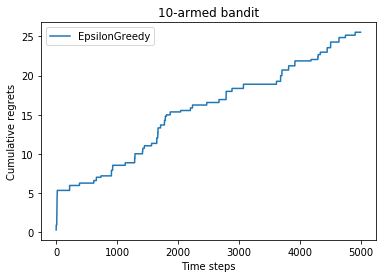

In [47]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()


np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy_Solver(bandit_10_arm, epsilon=0.01)
# T次尝试
T = 5000
epsilon_greedy_solver.run(T)
print("估算的Q", epsilon_greedy_solver.Q)
print("隐藏的概率", bandit_10_arm.probs)

print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
# 绘制累积懊悔随时间变化的图像
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

# epsilon-贪婪算法的累积懊悔为：25.526630933945313

<div class="alert alert-block alert-warning">

**测试3：测试不同$\epsilon$对性能影响 （10分）**。

</div>

将$\epsilon$分别设置为1e-4, 1e-3, 1e-1, 0.2e-1, 0.5e-1， 跑实验对比分析

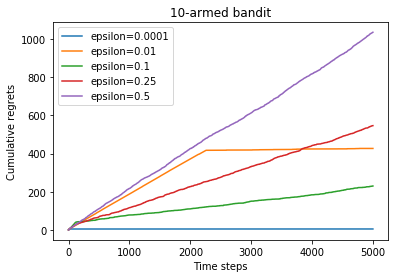

In [48]:
#y是累计懊悔
np.random.seed(1)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5] #epsilon表示探索概率
epsilon_greedy_solver_list = [
    EpsilonGreedy_Solver(bandit_10_arm, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
# T次尝试
T = 5000
for solver in epsilon_greedy_solver_list:
    solver.run(5000)
# 绘制累积懊悔随时间变化的图像   
plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)


<div class="alert alert-block alert-warning">

**测试4：测试动态调整$\epsilon$对性能影响(5分)**。
$$\epsilon = \frac{1}{t}$$
</div>

拉杆0获奖真实期望为 0.42， 估算期望为0.40
拉杆1获奖真实期望为 0.72， 估算期望为0.73
拉杆2获奖真实期望为 0.00， 估算期望为0.00
拉杆3获奖真实期望为 0.30， 估算期望为0.33
拉杆4获奖真实期望为 0.15， 估算期望为0.00
拉杆5获奖真实期望为 0.09， 估算期望为0.33
拉杆6获奖真实期望为 0.19， 估算期望为0.00
拉杆7获奖真实期望为 0.35， 估算期望为0.00
拉杆8获奖真实期望为 0.40， 估算期望为0.60
拉杆9获奖真实期望为 0.54， 估算期望为0.67
epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


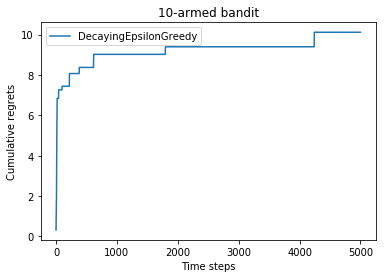

In [49]:
np.random.seed(1)
decay_epsilon_greedy_solver = EpsilonGreedy_Solver(bandit_10_arm, use_decay=True)

# T次尝试
T = 5000
decay_epsilon_greedy_solver.run(T)

# T次尝试之后，我们来查看结果：
# 基于估算的Q，可以简单测试是否达到最佳拉杆的索引及其获奖概率，进行验证
for a in range(10):
    print(f"拉杆{a}获奖真实期望为{bandit_10_arm.probs[a]: .2f}， 估算期望为{decay_epsilon_greedy_solver.Q[a]:.2f}")
    
print('epsilon值衰减的贪婪算法的累积懊悔为：', decay_epsilon_greedy_solver.regret)
plot_results([decay_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

# epsilon值衰减的贪婪算法的累积懊悔为：10.114334931260183

<div class="alert alert-block alert-warning">

**总结 （15分）**。
</div>
提示：从探索与利用的平衡角度，对多臂老虎机问题进行分析和展望。



## 一个核心要点：由于奖励的概率分布是未知的，因此我们需要在“探索拉杆的获奖概率”和“根据经验选择获奖最多的拉杆”中进行权衡 
```
    由测试3这个图，可以看出探索概率和累计懊悔有着一定的关系。

    当探索概率较大，例如0.5这条线，累计懊悔呈现y=x上升趋势，且函数是发散的。当探索概率维持在较小范围，可以看出累计懊悔函数是收敛的。

    当探索概率接近于0，从图中可以看出，累计懊悔的极限也是0。这表明减少探索可能导致更好的长期性能，因为它降低了不确定性并允许Agent专注于基于先验知识选择最有前途的手臂。但是，完全消除探索并非总是最优方案，特别是在学习过程开始时或环境发生变化时。在这种情况下，某些程度的探索是必要的，以适应新情况并发现潜在的更佳选项。
```

## ε=1/t 随时间递减的贪婪策略：
```
    有助于在探索和利用之间取得平衡，让学习者在早期收集足够的信息的同时逐渐专注于优化奖励。
在学习过程的早期阶段，当总计数量很小时，ε的值会比较大，导致更多的探索行为。随着总计数的增加，ε的值会降低，从而导致对已知最佳手臂的更多利用
```